In [1]:
import gc
import json
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm_notebook
from utils import FlattenDataSimple, loadJSON, loadpkl

%matplotlib inline

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# load csv
profiles = pd.read_csv('../input/data_set_phase1/profiles.csv')
test_plans = pd.read_csv('../input/data_set_phase1/test_plans.csv')
test_queries = pd.read_csv('../input/data_set_phase1/test_queries.csv')
train_clicks = pd.read_csv('../input/data_set_phase1/train_clicks.csv')
train_plans = pd.read_csv('../input/data_set_phase1/train_plans.csv')
train_queries = pd.read_csv('../input/data_set_phase1/train_queries.csv')

In [3]:
# merge click
train_plans = pd.merge(train_plans, train_clicks[['sid','click_mode']], on='sid', how='outer')

# fill na
train_plans['click_mode'].fillna(0, inplace=True)

# set test target as nan
test_plans['click_mode'] = np.nan

# merge train & test
plans = train_plans.append(test_plans)

del train_plans, test_plans
gc.collect()

# reset index
plans.reset_index(inplace=True,drop=True)

# convert json
for key in tqdm_notebook(['distance', 'price', 'eta', 'transport_mode']):
    plans[key] = plans.plans.apply(lambda x: loadJSON(x,key))

# flatten
plans_df = [FlattenDataSimple(plans, key) for key in tqdm_notebook(['distance', 'price', 'eta', 'transport_mode'])]
plans_df = pd.concat(plans_df,axis=1)

# drop na
plans_df.dropna(inplace=True)

# merge plan_time & click_mode
plans_df = pd.merge(plans_df.reset_index(), plans[['sid','plan_time', 'click_mode']], on='sid',how='outer')

# cleaning
for c in plans_df.columns.to_list():
    if 'price' in c:
        plans_df[c] = plans_df[c].replace('',0)

plans_df['plan_time'] = pd.to_datetime(plans_df['plan_time'])

# datetime features
plans_df['weekday'] = plans_df['plan_time'].dt.weekday
plans_df['hour'] = plans_df['plan_time'].dt.hour
plans_df['weekday_count'] = plans_df['weekday'].map(plans_df['weekday'].value_counts())
plans_df['hour_count'] = plans_df['hour'].map(plans_df['hour'].value_counts())

In [5]:
plans_df.head()

,sid,plans_0_distance,plans_1_distance,plans_2_distance,plans_3_distance,plans_4_distance,plans_5_distance,plans_6_distance,plans_0_price,plans_1_price,...,plans_3_transport_mode,plans_4_transport_mode,plans_5_transport_mode,plans_6_transport_mode,plan_time,click_mode,weekday,hour,weekday_count,hour_count
0,1461993,4792.0,3452.0,3790.0,3790.0,4955.0,4038.0,3394.0,300.0,0.0,...,4.0,9.0,7.0,5.0,2018-10-27 17:57:29,4.0,5,17,99366,42562
1,2116486,7413.0,4599.0,6024.0,6024.0,7401.0,5739.0,4530.0,300.0,0.0,...,4.0,9.0,1.0,5.0,2018-11-18 18:42:04,2.0,6,18,82824,35687
2,3043170,7086.0,3788.0,5231.0,5231.0,7067.0,4478.0,3578.0,300.0,0.0,...,4.0,2.0,1.0,5.0,2018-10-22 18:04:56,9.0,0,18,75935,35687
3,3249726,5829.0,3939.0,4661.0,4661.0,4231.0,4186.0,3694.0,300.0,0.0,...,4.0,7.0,1.0,5.0,2018-11-25 17:41:57,9.0,6,17,82824,42562
4,3375348,4244.0,4244.0,4274.0,7381.0,7363.0,7461.0,4208.0,1800.0,0.0,...,9.0,7.0,2.0,5.0,2018-11-24 22:25:30,9.0,5,22,99366,15974


In [7]:
profiles.head()

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,196356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,204083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,170667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,115511,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,129719,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# merge train & test
queries_df = train_queries.append(test_queries)

del train_queries, test_queries
gc.collect()

# to datetime
queries_df['req_time'] = pd.to_datetime(queries_df['req_time'])

# features distance
queries_df['x_o']=queries_df['o'].apply(lambda x: x.split(',')[0]).astype(float)
queries_df['y_o']=queries_df['o'].apply(lambda x: x.split(',')[1]).astype(float)
queries_df['x_d']=queries_df['d'].apply(lambda x: x.split(',')[0]).astype(float)
queries_df['y_d']=queries_df['d'].apply(lambda x: x.split(',')[1]).astype(float)

queries_df['queries_distance'] = np.sqrt((queries_df['x_o']-queries_df['x_d'])**2 + (queries_df['y_o']-queries_df['y_d'])**2)

queries_df['queries_x_o_count']=queries_df['x_o'].map(queries_df['x_o'].value_counts())
queries_df['queries_y_o_count']=queries_df['y_o'].map(queries_df['y_o'].value_counts())
queries_df['queries_x_d_count']=queries_df['x_d'].map(queries_df['x_d'].value_counts())
queries_df['queries_y_d_count']=queries_df['y_d'].map(queries_df['y_d'].value_counts())

In [31]:
queries_df.head()

,sid,pid,req_time,o,d,x_o,y_o,x_d,y_d,queries_distance,queries_x_o_count,queries_y_o_count,queries_x_d_count,queries_y_d_count
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96",116.29,39.97,116.32,39.96,0.031623,15792,20412,37054,16937
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79",116.39,39.84,116.33,39.79,0.078102,33319,12712,20339,4843
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00",116.31,39.93,116.27,40.00,0.080623,27853,33989,14120,23584
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90",116.27,39.88,116.39,39.90,0.121655,11881,15663,44759,46675
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86",116.34,39.96,116.37,39.86,0.104403,18655,17994,35540,25996


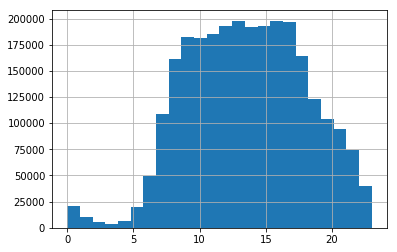

In [6]:
plans_df['plan_time'].dt.hour.hist(bins=24)

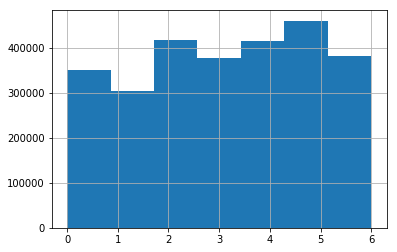

In [7]:
plans_df['plan_time'].dt.weekday.hist(bins=7)

In [39]:
quer

,plans_0_distance,plans_1_distance,plans_2_distance,plans_3_distance,plans_4_distance,plans_5_distance,plans_6_distance,sid
0,32303,33678.0,33678.0,32099.0,30446.0,NaN,NaN,1709112
1,3427,3251.0,3251.0,3227.0,3227.0,NaN,NaN,3327773
2,36234,29545.0,29545.0,33295.0,NaN,NaN,NaN,3285959
3,11450,9100.0,10870.0,10870.0,11722.0,NaN,NaN,1616170
4,18495,19111.0,19111.0,17117.0,NaN,NaN,NaN,351369
5,32486,NaN,NaN,NaN,NaN,NaN,NaN,749203
6,4935,4434.0,4434.0,4228.0,3711.0,NaN,NaN,3005789
7,22103,18601.0,18601.0,24067.0,19733.0,NaN,NaN,1897386
8,12422,12548.0,12548.0,12542.0,8641.0,13657.0,NaN,845203
9,2162,2647.0,2176.0,2647.0,2176.0,NaN,NaN,536341


In [7]:
train_plans.head()

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."
3,1616170,2018-10-03 14:42:40,"[{""distance"": 11450, ""price"": 400, ""eta"": 2801..."
4,351369,2018-10-05 19:52:37,"[{""distance"": 18495, ""price"": 600, ""eta"": 4271..."


In [8]:
train_queries.head()

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90"
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86"


In [12]:
train_queries['x_o']=train_queries.o.apply(lambda x: x.split(',')[0]).astype(float)
train_queries['y_o']=train_queries.o.apply(lambda x: x.split(',')[1]).astype(float)
test_queries['x_o']=test_queries.o.apply(lambda x: x.split(',')[0]).astype(float)
test_queries['y_o']=test_queries.o.apply(lambda x: x.split(',')[1]).astype(float)

train_queries['x_d']=train_queries.d.apply(lambda x: x.split(',')[0]).astype(float)
train_queries['y_d']=train_queries.d.apply(lambda x: x.split(',')[1]).astype(float)
test_queries['x_d']=test_queries.d.apply(lambda x: x.split(',')[0]).astype(float)
test_queries['y_d']=test_queries.d.apply(lambda x: x.split(',')[1]).astype(float)

In [13]:
queries = train_queries.append(test_queries)
plans = train_plans.append(test_plans)

NameError: name 'train_plans' is not defined

In [14]:
sns.scatterplot(x='x_o', y='y_o',hue='is_test' ,data=queries)

ValueError: Could not interpret input 'is_test'

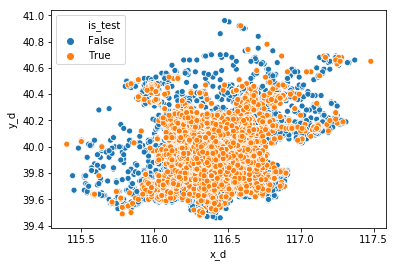

In [17]:
sns.scatterplot(x='x_d', y='y_d',hue='is_test' ,data=queries)

In [5]:
plans.reset_index(inplace=True,drop=True)

In [6]:
plans

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."
3,1616170,2018-10-03 14:42:40,"[{""distance"": 11450, ""price"": 400, ""eta"": 2801..."
4,351369,2018-10-05 19:52:37,"[{""distance"": 18495, ""price"": 600, ""eta"": 4271..."
5,749203,2018-10-01 07:03:52,"[{""distance"": 32486, ""price"": """", ""eta"": 2491,..."
6,3005789,2018-10-22 11:45:20,"[{""distance"": 4935, ""price"": 300, ""eta"": 1568,..."
7,1897386,2018-11-13 18:51:27,"[{""distance"": 22103, ""price"": 500, ""eta"": 3361..."
8,845203,2018-11-26 12:43:56,"[{""distance"": 12422, ""price"": 400, ""eta"": 2324..."
9,536341,2018-11-23 19:34:38,"[{""distance"": 2162, ""price"": 200, ""eta"": 1239,..."


In [7]:
for key in tqdm_notebook(['distance', 'price', 'eta', 'transport_mode']):
    plans[key] = plans.plans.apply(lambda x: loadJSON(x,key))

In [8]:
# flattenData
plans_df = [FlattenData(plans, key) for key in tqdm_notebook(['distance', 'price', 'eta', 'transport_mode'])]
plans_df = pd.concat(plans_df,axis=1)

In [5]:
df = loadpkl('../features/plans.pkl')

In [ ]:
plans_df.groupby('sid').max()